# Python vSLAM
##### https://learnopencv.com/monocular-slam-in-python/#aioseo-what-is-visual-slam

In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [21]:
image1 = cv2.imread(r'rgbd_dataset_freiburg3_long_office_household\rgb\1341847980.722988.png')

In [22]:
image2 = cv2.imread(r'rgbd_dataset_freiburg3_long_office_household\rgb\1341847980.754743.png')

### Identify keypoints and descriptors.

### ORB Feature Extraction Explained:
Main idea of ORB Feature extraction is, if a pixel is very different from the neighbour pixels (too bright or too dark), it is more likely to be a corner point. Its entire procedure is as follows,

- Select pixel $p$ in the image assuming its brightness as $I_p$.
- Set a threshold $T$ (for example, 20% of $I_p$ ).
- Take the pixel $p$ as the centre, and select the 16 pixels on a circle with a radius of 3.
- If there are consecutive $N$ points on the selected circle whose brightness is greater than $I_p + T$ or less than $I_p − T$, then the central pixel p can be considered a feature point. Value of $N$ is usually 12, 11 or 9.
- Iterate through the above four steps on each pixel.


A trick is used to reject most non-corner points by first examining the pixels at positions 1, 9, 5, and 13. At least N of these pixels must have a brightness greater than $(I_p + T)$ or less than $(I_p - T)$ for the point to be considered a corner.

**Key point**: The key point refers to the 2D position(on image) of the feature point. Some types of key points also hold other information, such as the orientation and size.

**Descriptor**: The descriptor is usually a vector, describing the information of the pixels around the key point. Descriptors should be designed such that features with similar appearances have similar descriptors. Thus, if two feature descriptors are close in vector space, they can be considered the same feature.

In [23]:
orb = cv2.ORB_create(nfeatures=5000)

keypts1,descs1 = orb.detectAndCompute(image1,None)

keypts2,descs2 = orb.detectAndCompute(image2,None)

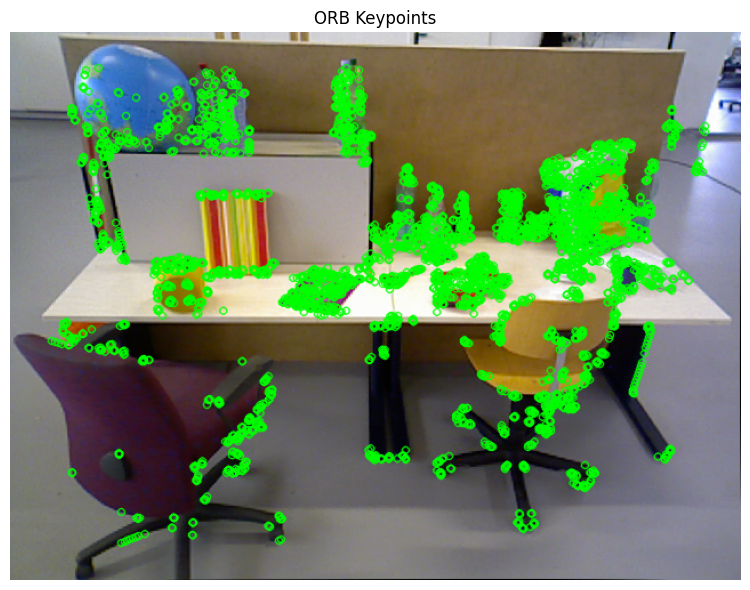

In [24]:
image_with_keypoints = cv2.drawKeypoints(image1, keypts1, None, color=(0, 255, 0), flags=0)

# Convert BGR to RGB for correct color rendering in matplotlib
image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

# Show using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(image_with_keypoints_rgb)
plt.title("ORB Keypoints")
plt.axis('off')
plt.tight_layout()
plt.show()

### Feature Matching

In [25]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
matches = bf.match(descs1,descs2)

matches = sorted(matches, key=lambda x: x.distance)

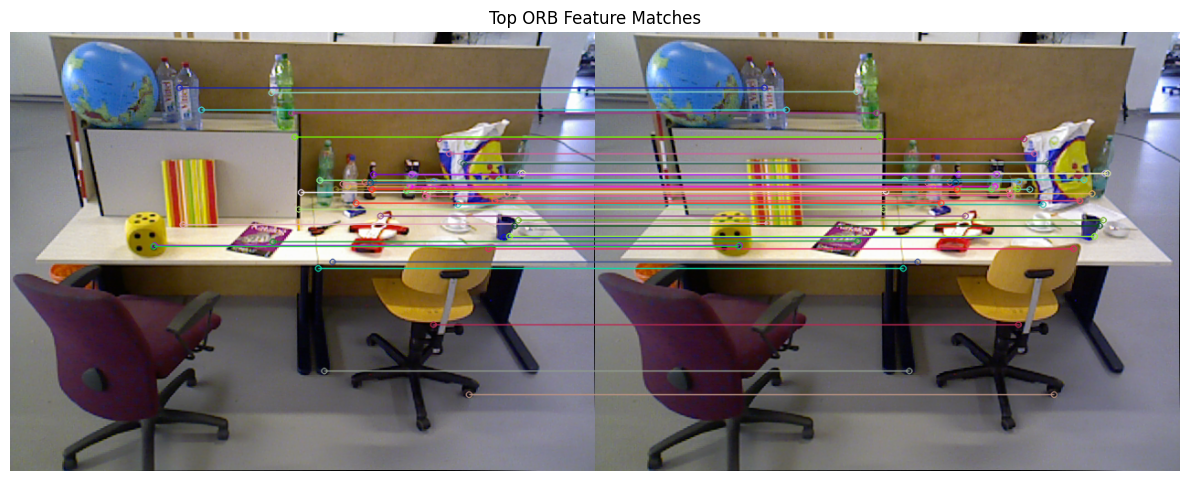

In [26]:

# Assuming image1, image2, keypts1, keypts2, and matches are already defined
num_matches_to_draw = 50
match_img = cv2.drawMatches(image1, keypts1, image2, keypts2, matches[:num_matches_to_draw], None, flags=2)

# Convert BGR (OpenCV) to RGB (Matplotlib)
match_img_rgb = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

# Show using matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(match_img_rgb)
plt.title('Top ORB Feature Matches')
plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
# Assume image1, image2 are grayscale images
# Assume keypts1 are ORB keypoints from image1

# Extract 2D coordinates from KeyPoint objects
pts1 = np.array([kp.pt for kp in keypts1], dtype=np.float32).reshape(-1, 1, 2)

# Set Lucas-Kanade optical flow parameters
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Calculate optical flow
pts2, status, err = cv2.calcOpticalFlowPyrLK(image1, image2, pts1, None, **lk_params)

# Select only the successfully tracked points
good_new = pts2[status.ravel() == 1]
good_old = pts1[status.ravel() == 1]

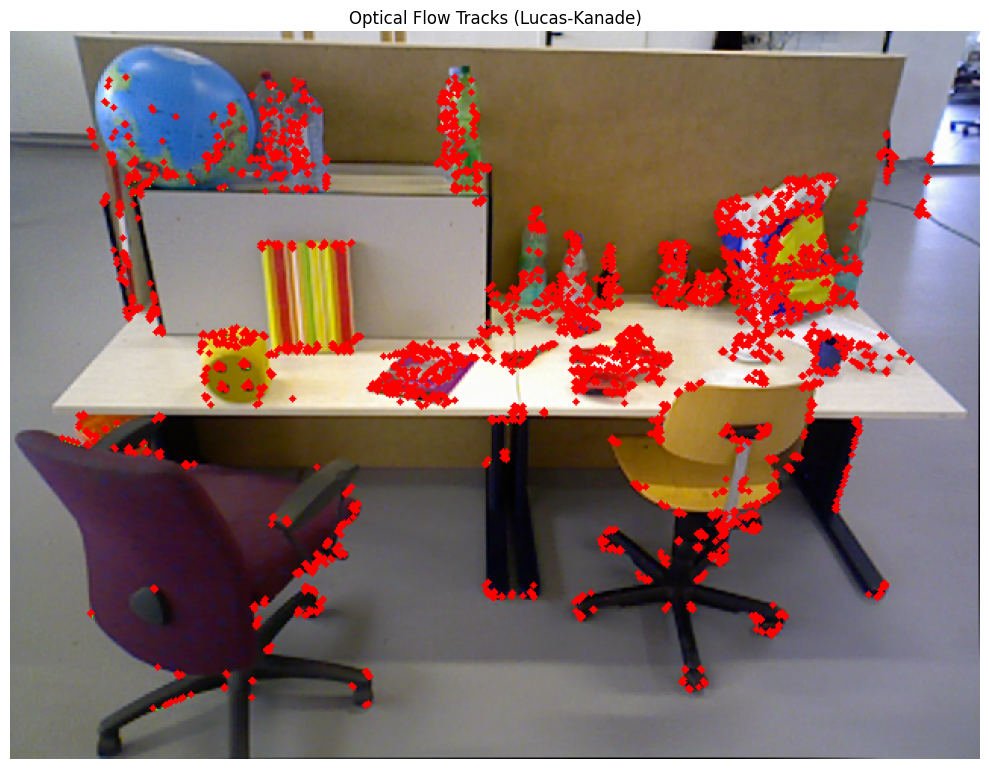

In [28]:
# Use color image directly or convert if grayscale
if len(image2.shape) == 2 or image2.shape[2] == 1:
    image2_color = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
else:
    image2_color = image2.copy()

# Draw the optical flow tracks
for (new, old) in zip(good_new, good_old):
    a, b = new.ravel()
    c, d = old.ravel()
    cv2.line(image2_color, (int(a), int(b)), (int(c), int(d)), color=(0, 255, 0), thickness=1)
    cv2.circle(image2_color, (int(a), int(b)), radius=2, color=(0, 0, 255), thickness=-1)

# Convert BGR to RGB for matplotlib
image2_rgb = cv2.cvtColor(image2_color, cv2.COLOR_BGR2RGB)

# Show using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(image2_rgb)
plt.title("Optical Flow Tracks (Lucas-Kanade)")
plt.axis('off')
plt.tight_layout()
plt.show()

### **Pose Estimation**
Camera Pose Estimation is very important because you can estimate the 3D map only after you do that. Pose estimation is mathematically intensive.

**World Coordinates Frame** : global reference frame \
**Camera Coordinate Frame** : location of the camera as the origin and reference the location of any object wrt that camera location
The relationship between the camera and world coordinate frames (3D to 3D), defined by some parameters represented as Extrinsic Matrix $[R \mid t]$.\
**Image Coordinate Frame** : 
- 2D coordinate in the image 
- Image coordinate frame can be related to the camera coordinate frame through the intrinsic camera parameters also known as Intrinsic Matrix (K)

<img src="image_formation.jpg" width="540" height="270" />


$$ X_c = [R|t]X_w = RX_w + t $$
- R  = rotation matrix
- t = translation matrix in (x,y,x)
- $X_w$ = 3D coordinates in world frame
- $X_c$ = 3D coordinates in camera coordinate frame
- $[R|t]$ = extrinsic matrix (4x4)


$$ x_i = KX_c$$
- K = intrinsic Matrix(3x1)
- $x_i$ = 2D coordinates in image plane
- $X_c$ = 3D coordinates in camera coordinate frame

### **Epipolar geometry**

When the camera is monocular, we only know the 2D pixel coordinates, so the problem is to estimate the motion according to two sets of 2D points. \
You can’t estimate depth from just a single image. To estimate depth, you need more than one image. When multiple images come into play, we use epipolar geometry to figure out depth. In Monocular SLAM, we use image frames from different timestamps to estimate depth, making epipolar geometry super important. 

<img src="epipolar_geometry.jpg" width="540" height="270" /> \
- The epipolar plane is defined by the optical centers of the two cameras $O_l$ and $O_r$ and a 3D point $P$
- intersection of the epipolar plane and image frames represents the epipolar lines $l_1$ and $l_2$. 
- These lines indicate where corresponding points must lie, reducing the search for matches from 2D to 1D. 
- To determine the motion between frames $I_l$ and $I_r$, defined by rotation $R$ and translation $t$, feature points $u_l$ in $I_l$ and $p_r$ in $I_r$ must correspond correctly, projecting the same 3D point $P$. 
- The fundamental matrix $F$, encapsulates this relationship.

<img src="epipolar_geometry_formulas.jpg" width="540" height="270" /> \

<img src="epipolar_geometry_formulas2.jpg" width="280" height="280|" /> 